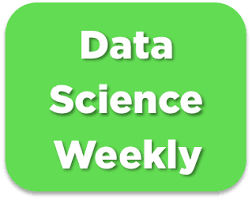

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [4]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [5]:
df = data_sample.copy()

In [6]:
df.describe(include = 'all')

,country,age,new_user,source,total_pages_visited,converted
count,10000,10000.000000,10000.000000,10000,10000.000000,10000.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,5633,NaN,NaN,4912,NaN,NaN
mean,NaN,30.615000,0.690400,NaN,4.842300,0.032900
std,NaN,8.150179,0.462352,NaN,3.369238,0.178384
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [7]:
df.nunique()

country                 4
age                    49
new_user                2
source                  3
total_pages_visited    26
converted               2
dtype: int64

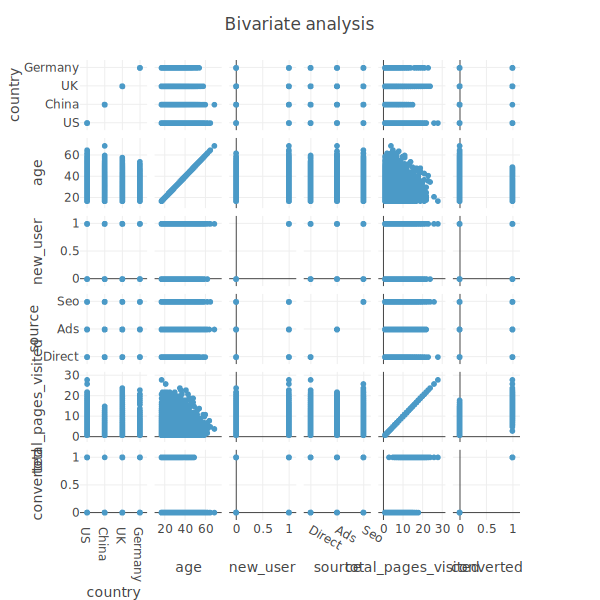

In [8]:
# Visualize pairwise dependencies
fig = px.scatter_matrix(df)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height=600, width = 600)
fig.show()

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [9]:
features_list = ['age', 'total_pages_visited', 'country', 'new_user', 'source']
numeric_features = ['age', 'total_pages_visited']
categorical_features = ['country', 'new_user', 'source']
numeric_indices = [0, 1]
categorical_indices = [2, 3, 4]
target_variable = 'converted'

In [10]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['age', 'total_pages_visited', 'country', 'new_user', 'source'], dtype='object')



In [20]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=42)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [21]:
# Put here all the preprocessings

print("Encoding categorical features and standardizing numerical features...")

numeric_transformer =  Pipeline(steps=[
    ('imputer', KNNImputer()), # missing values in Age will be replaced by columns' mean
    ("polynomial", PolynomialFeatures()), # on cree les nouvelles variables
    ('scaler', StandardScaler(),) # on scale en dernier pour etre sur que les variables sont sur la meme echelle
])
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])

X_train = preprocessor.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.         -1.27650481 -0.2618471  -1.09917545 -0.62798717 -0.36030223
   0.          0.          1.          1.          0.          0.        ]
 [ 0.         -0.18867057 -0.56090876 -0.29452473 -0.56308521 -0.493381
   0.          0.          0.          1.          0.          0.        ]
 [ 0.          0.65742272 -0.56090876  0.53567045 -0.36837933 -0.493381
   0.          0.          1.          0.          0.          1.        ]
 [ 0.         -0.9138934   0.93439955 -0.86380143  0.33627053  0.55223785
   0.          0.          1.          1.          0.          1.        ]
 [ 0.          1.26177508 -0.56090876  1.2381433  -0.2293037  -0.493381
   0.          1.          0.          1.          0.          0.        ]]


In [22]:
# Train model
print("Train model...")
classifier = LogisticRegression(C=0.5)
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [23]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [24]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.          0.17394084 -0.2618471   0.03937794 -0.18294516 -0.36030223
   0.          0.          1.          1.          0.          1.        ]
 [ 0.         -0.0678001   0.03721457 -0.18687305  0.02103243 -0.18920097
   0.          1.          0.          1.          0.          1.        ]
 [ 0.          0.05307037  0.03721457 -0.07557216  0.06739097 -0.18920097
   0.          0.          0.          1.          0.          1.        ]
 [ 0.          2.47047978  0.03721457  2.91677971  0.99456184 -0.18920097
   0.          0.          1.          0.          0.          1.        ]
 [ 0.         -1.27650481 -0.56090876 -1.09917545 -0.81342134 -0.493381
   0.          0.          1.          1.          1.          0.        ]]


In [25]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [26]:
from sklearn.metrics import accuracy_score

print("accuracy on train set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))

accuracy on train set :  0.9860671867313233
accuracy on test set :  0.9864888607772858


In [27]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7604229607250756
f1-score on test set :  0.7664743395080474


In [28]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[219458    862]
 [  2310   5034]]

Confusion matrix on test set : 
[[54885   195]
 [  574  1262]]



In [29]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.87      0.69      0.77      1836

    accuracy                           0.99     56916
   macro avg       0.93      0.84      0.88     56916
weighted avg       0.99      0.99      0.99     56916



# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [21]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

LogisticRegression(C=0.5)

In [22]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[[28 16 'UK' 0 'Seo']
 [22 5 'UK' 1 'Direct']
 [32 1 'China' 1 'Seo']
 [32 6 'US' 1 'Ads']
 [25 3 'China' 0 'Seo']]


In [23]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(pd.DataFrame(X_without_labels,columns=features_list))
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.         -0.30955685  3.33018905 -0.39852171  2.78746551  4.21083954
   0.          1.          0.          0.          0.          1.        ]
 [ 0.         -1.03522161  0.03801145 -0.9463237  -0.34946028 -0.18874497
   0.          1.          0.          1.          1.          0.        ]
 [ 0.          0.17421967 -1.15914405  0.03971988 -1.07336623 -0.64584466
   0.          0.          0.          1.          0.          1.        ]
 [ 0.          0.17421967  0.33730032  0.03971988  0.41156906  0.02075905
   0.          0.          1.          1.          0.          0.        ]
 [ 0.         -0.67238923 -0.5605663  -0.68885676 -0.67428987 -0.4934781
   0.          0.          0.          0.          0.          1.        ]]


In [24]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_log_reg.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**